In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,5)

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Загружаем данные
df = pd.read_csv('data.csv')[[
    'full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'kitch_sq',
    'state', 'area_m', 'raion_popul', 'green_zone_part', 'indust_part', 'preschool_education_centers_raion',
    'school_education_centers_raion', 'hospital_beds_raion', 'healthcare_centers_raion', 'sport_objects_raion',
    'additional_education_raion', 'shopping_centers_raion', 'office_raion', 'ID_metro', 'metro_min_walk', 'kindergarten_km',
    'school_km', 'park_km', 'green_zone_km', 'industrial_km', 'water_km', 'mkad_km', 'ttk_km', 'sadovoe_km', 'bulvar_ring_km',
    'kremlin_km', 'ts_km', 'big_market_km','market_shop_km', 'fitness_km', 'university_km', 'workplaces_km', 'shopping_centers_km',
    'office_km', 'preschool_km', 'price_doc'
]]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Data columns (total 44 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   full_sq                            30471 non-null  int64  
 1   life_sq                            24088 non-null  float64
 2   floor                              30304 non-null  float64
 3   max_floor                          20899 non-null  float64
 4   material                           20899 non-null  float64
 5   build_year                         16866 non-null  float64
 6   num_room                           20899 non-null  float64
 7   kitch_sq                           20899 non-null  float64
 8   state                              16912 non-null  float64
 9   area_m                             30471 non-null  float64
 10  raion_popul                        30471 non-null  int64  
 11  green_zone_part                    30471 non-null  flo

In [3]:
# Основные признаки, относящиеся к самому объекту, а не окружающей местности, самые важные для визуального анализа
main_colums = [
    'full_sq', 'life_sq', 'floor', 'max_floor', 'material',
    'build_year', 'num_room', 'kitch_sq','state', 'price_doc'
]

extra_columns = [
    'area_m', 'raion_popul', 'green_zone_part', 'indust_part', 'preschool_education_centers_raion',
    'school_education_centers_raion', 'hospital_beds_raion', 'healthcare_centers_raion', 'sport_objects_raion',
    'additional_education_raion', 'shopping_centers_raion', 'office_raion', 'ID_metro', 'metro_min_walk', 'kindergarten_km',
    'school_km', 'park_km', 'green_zone_km', 'industrial_km', 'water_km', 'mkad_km', 'ttk_km', 'sadovoe_km', 'bulvar_ring_km',
    'kremlin_km', 'ts_km', 'big_market_km','market_shop_km', 'fitness_km', 'university_km', 'workplaces_km', 'shopping_centers_km',
    'office_km', 'preschool_km'
]

# Дополнительные признаки

In [4]:
# функция для оценки качества модели, так же добавляет записи в историю изменений качества модели
quality_history = []

def get_score(df):
    results = []
    
     # Кодируем категориальные признаки
    dummy_df = pd.get_dummies(df)
    
     # Заполняем пропуски нулями
    dummy_df.fillna(0, inplace=True)
    
    for seed in range(10):
        X_train, X_test, y_train, y_test = train_test_split(
            StandardScaler().fit_transform(dummy_df.loc[:, ~(dummy_df.columns == 'price_doc')]),
            dummy_df.price_doc, 
            random_state=seed
        ) 
        model = Ridge().fit(X_train, y_train)
        results.append(model.score(X_test, y_test))
        
    result = np.mean(results)    
    
    quality_history.append(result)
        
    print('Качество модели: ', result)
    

In [5]:
# Модели для заполнения пропусков
def fill_category(data, train_columns, target_column):
    lda = LinearDiscriminantAnalysis()
    train = data[~(data[target_column].isna())]
    lda.fit(pd.get_dummies(train[train_columns]), train[target_column])
    data['predict'] = lda.predict(pd.get_dummies(data[train_columns]))
    data[target_column] = np.where(
        data[target_column].isna(), 
        data['predict'], 
        data[target_column]
    )

    data = data.drop('predict', 1)
    
    return data

def fill_value(data, train_columns, target_column):
    ridge =  Ridge()
    train = data[~(data[target_column].isna())]
    ridge.fit(pd.get_dummies(train[train_columns]), train[target_column])
    data['predict'] = ridge.predict(pd.get_dummies(data[train_columns]))
    data[target_column] = np.where(
        data[target_column].isna(), 
        data['predict'], 
        data[target_column]
    )

    data = data.drop('predict', 1)
    
    return data

In [6]:
# Создаем базовую модель, которую постепенно будем улучшать

get_score(df)

Качество модели:  -17.436147505998626


## price_doc
стоимость, целевая переменная

In [7]:
# Ищем выбросы и ошибки вручную

df[main_colums].sort_values(by='price_doc').head(10)

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,price_doc
20244,72,37.0,11.0,16.0,1.0,2006.0,2.0,12.0,1.0,100000
1167,38,23.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,190000
1169,47,31.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,200000
9221,40,25.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,260000
3258,31,19.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,300000
20388,63,NaN,11.0,1.0,1.0,2014.0,1.0,1.0,1.0,301693
2677,37,18.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,331464
1596,59,0.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,338570
634,70,49.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,340000
1262,66,36.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,354289


In [8]:
df[main_colums].sort_values(by='price_doc').tail(10)

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,price_doc
29656,211,162.0,5.0,5.0,2.0,1914.0,6.0,19.0,3.0,70000000
5728,210,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,71033632
11085,132,76.0,16.0,28.0,4.0,2006.0,4.0,12.0,NaN,71200000
27460,151,NaN,15.0,1.0,1.0,2015.0,4.0,1.0,1.0,71249624
3557,157,89.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,77000000
6319,206,128.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,78802248
19095,184,85.0,10.0,47.0,4.0,2004.0,1.0,54.0,4.0,80777440
7457,185,66.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,91066096
28326,220,144.0,3.0,5.0,2.0,1927.0,9.0,17.0,3.0,95122496
2118,55,31.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,111111112


In [9]:
# Самая дорогая квартира маленькая и со странной ценой, удаляем
df = df[df.price_doc < 100000000]
get_score(df)

Качество модели:  -13.799916656435096


<AxesSubplot:xlabel='price_doc'>

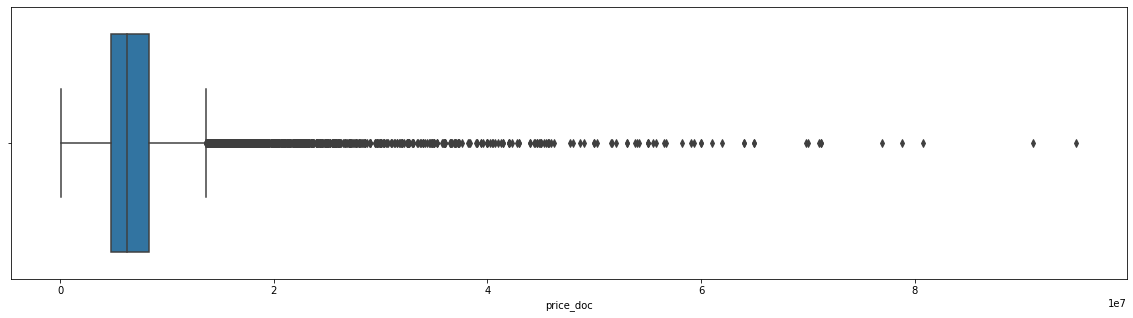

In [10]:
# Ищем выбросы и ошибки визуально, длинный правый хвост

sns.boxplot(df['price_doc'])

In [11]:
# Подсчитываем вероятные выбросы
df[df.price_doc > 65000000].price_doc.size

10

In [12]:
# Некритично, удаляем
df = df[df.price_doc < 65000000]
get_score(df)

Качество модели:  -18.16032485038571


<AxesSubplot:xlabel='price_doc', ylabel='Count'>

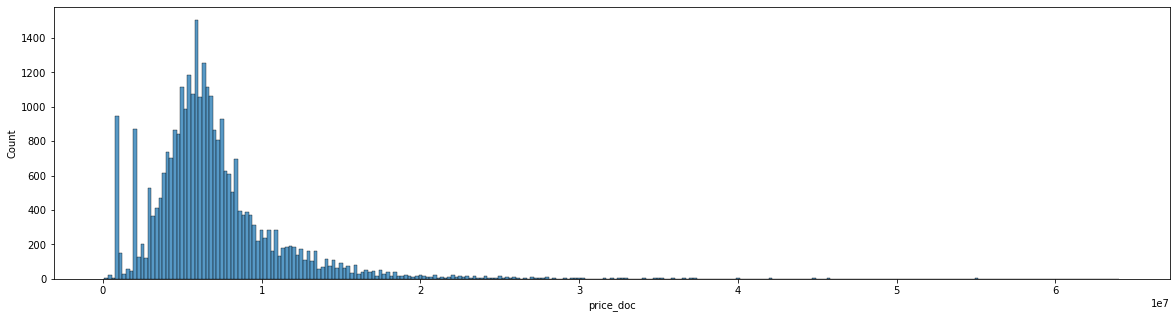

In [13]:
# Изучаем распределение
sns.histplot(df['price_doc'])

<AxesSubplot:xlabel='price_doc', ylabel='Count'>

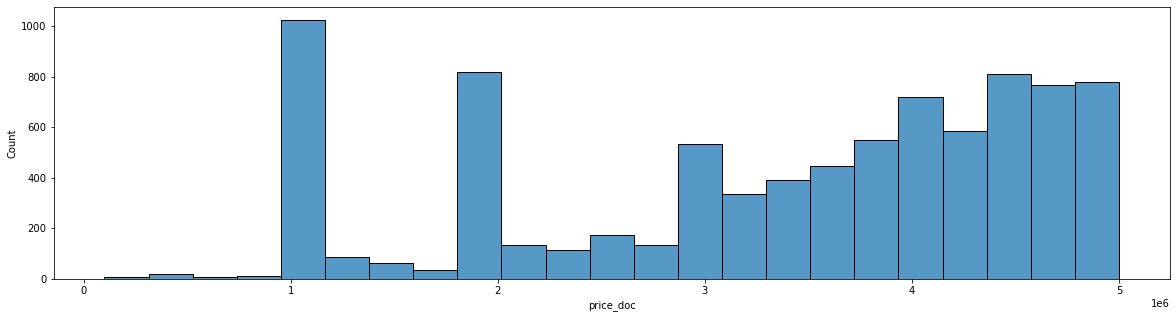

In [14]:
# Подробней изучим странные пики на гистрограмме
# Думаю, любовь людей к круглым числам не настолько сильна
# Вероятней, это сделки с неполной суммой в договоре, для модели нерелевантны
sns.histplot(df[df['price_doc'] < 5000000]['price_doc'])

In [15]:
# подсчитаем число возможных фиктивных сделок
df[(df.price_doc == 1000000) | (df.price_doc == 2000000) | (df.price_doc == 3000000)].price_doc.size

1836

In [16]:
# это примерно 6% от всех данных, но речь идет о целевой переменной, так что, думаю, удалить имеет смысл

df = df[~(df.price_doc == 1000000) | (df.price_doc == 2000000) | (df.price_doc == 3000000)]
get_score(df)

Качество модели:  -46.218941207757595


## full_sq
площадь

In [17]:
# Ищем выбросы вручную

df[main_colums].sort_values(by='full_sq').head(10)

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,price_doc
17932,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,4425000
24296,0,77.0,4.0,17.0,1.0,0.0,3.0,0.0,1.0,8167508
26264,1,60.0,17.0,17.0,1.0,2014.0,2.0,1.0,1.0,5983900
16289,1,1.0,1.0,1.0,4.0,1.0,1.0,1.0,3.0,4457400
16738,1,1.0,1.0,1.0,4.0,1.0,1.0,1.0,3.0,7820575
22871,1,1.0,1.0,1.0,1.0,2015.0,1.0,1.0,1.0,4740000
23726,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4819000
22722,1,1.0,1.0,25.0,1.0,2014.0,1.0,1.0,1.0,4740000
26363,1,64.0,22.0,22.0,1.0,NaN,2.0,1.0,1.0,14430018
23048,1,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,27259184


In [18]:
df[main_colums].sort_values(by='full_sq').tail(10)

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,price_doc
1610,394,17.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,1050000
27793,407,407.0,4.0,4.0,4.0,2015.0,1.0,10.0,1.0,3134129
2425,412,17.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,6117000
7207,461,27.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,5750000
23715,603,NaN,16.0,18.0,1.0,NaN,2.0,1.0,NaN,6572700
5944,634,38.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,10200000
18341,634,NaN,3.0,17.0,1.0,NaN,2.0,0.0,NaN,6213200
22785,637,637.0,18.0,19.0,4.0,2016.0,2.0,10.0,1.0,4725142
2780,729,44.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,13250000
3527,5326,22.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,6868818


In [19]:
# Явный выброс, удаляем

df = df[df.full_sq < 1000]
get_score(df)

Качество модели:  -0.9174558018470076


In [20]:
# Явные ошибки в данных, даже министудия или комната не может быть меньше 8 метров
# подсчитаем число возможных ошибок
df[df.full_sq < 8].full_sq.size

28

In [21]:
# Удаляем ошибки 
df = df[df.full_sq >= 8]
get_score(df)

Качество модели:  -2.4187426266936054


<AxesSubplot:xlabel='full_sq'>

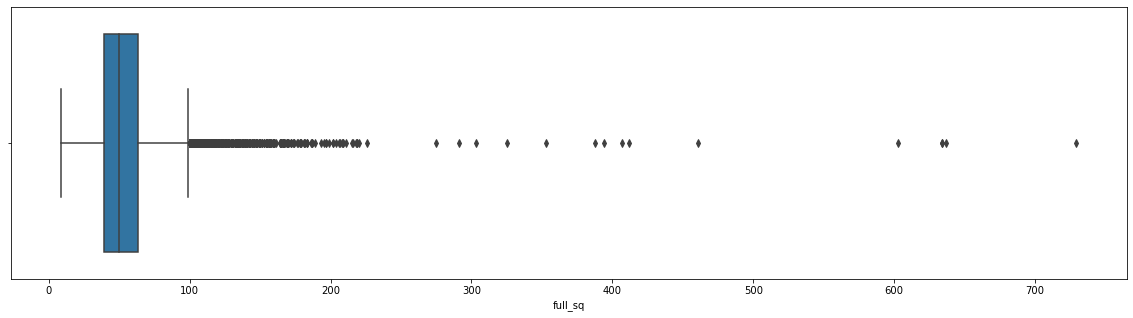

In [22]:
# В ящике с усами видны вероятные выбросы
sns.boxplot(df['full_sq'])

In [23]:
# Подсчитываем выбросы
df[df.full_sq > 250].full_sq.size

15

In [24]:
# Некритично, удаляем

df = df[df.full_sq < 250]
get_score(df)

Качество модели:  0.5531923951177257


<AxesSubplot:xlabel='full_sq', ylabel='Count'>

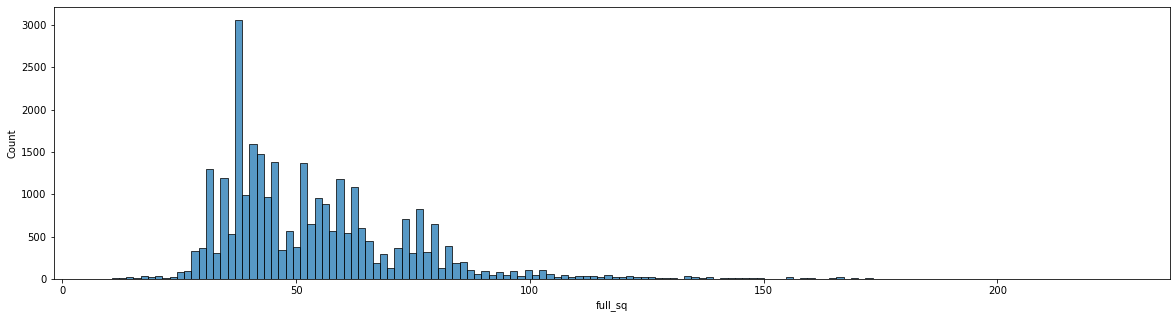

In [25]:
# Изучаем распределение
# Думаю, пики связаны с тем, что каждая дополнительная комната, это сразу 10+ метров к площади
sns.histplot(df['full_sq'])

In [26]:
# Для поиска выбросов добавляем признак цену за метр, в модели не используем

df['price_per_sq'] = df['price_doc'] / df['full_sq']

In [27]:
# Ищем выбросы вручную

df[main_colums+['price_per_sq']].sort_values(by='price_per_sq').head(10)

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,price_doc,price_per_sq
20244,72,37.0,11.0,16.0,1.0,2006.0,2.0,12.0,1.0,100000,1388.888889
1169,47,31.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,200000,4255.319149
20388,63,NaN,11.0,1.0,1.0,2014.0,1.0,1.0,1.0,301693,4788.777778
634,70,49.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,340000,4857.142857
1167,38,23.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,190000,5000.000000
1960,78,45.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,410000,5256.410256
1262,66,36.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,354289,5368.015152
1596,59,0.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,338570,5738.474576
854,80,45.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,472249,5903.112500
216,60,32.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,360000,6000.000000


In [28]:
df[main_colums+['price_per_sq']].sort_values(by='price_per_sq').tail(10)

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,price_doc,price_per_sq
26177,129,NaN,7.0,1.0,1.0,NaN,4.0,1.0,NaN,56739064,439837.705426
22694,125,67.0,7.0,9.0,2.0,1990.0,4.0,9.0,3.0,55000000,440000.000000
2696,76,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,33729308,443806.684211
17172,31,17.0,9.0,12.0,2.0,1954.0,1.0,6.0,3.0,14000000,451612.903226
15808,39,28.0,4.0,6.0,2.0,1931.0,2.0,6.0,4.0,17700000,453846.153846
10325,29,29.0,16.0,16.0,4.0,2013.0,1.0,1.0,1.0,13336080,459864.827586
17529,124,NaN,14.0,0.0,1.0,NaN,4.0,0.0,NaN,59325600,478432.258065
25419,94,NaN,9.0,9.0,4.0,NaN,2.0,1.0,NaN,45291152,481820.765957
24856,101,NaN,15.0,0.0,4.0,NaN,2.0,0.0,NaN,53787140,532545.940594
1188,9,44.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,6300000,700000.000000


In [29]:
# Явный выброс, удаляем

df = df[df.price_per_sq > 4000]
get_score(df.loc[:, ~(df.columns == 'price_per_sq')])

Качество модели:  0.5647030195630173


<AxesSubplot:xlabel='price_per_sq'>

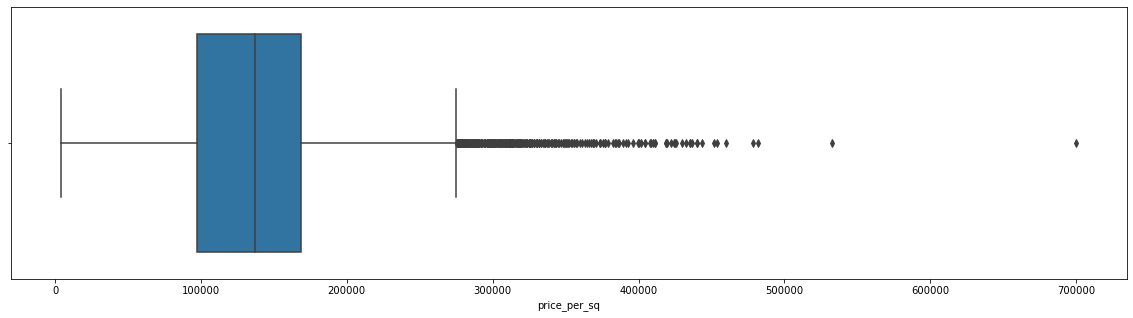

In [30]:
# В ящике с усами видны вероятные выбросы
sns.boxplot(df['price_per_sq'])

In [31]:
# Подсчитываем выбросы
df[df.price_per_sq > 500000].price_per_sq.size

2

In [32]:
# Некритично, удаляем

df = df[df.price_per_sq <= 500000]

get_score(df.loc[:, ~(df.columns == 'price_per_sq')])

Качество модели:  0.581197071950146


<AxesSubplot:xlabel='price_per_sq', ylabel='Count'>

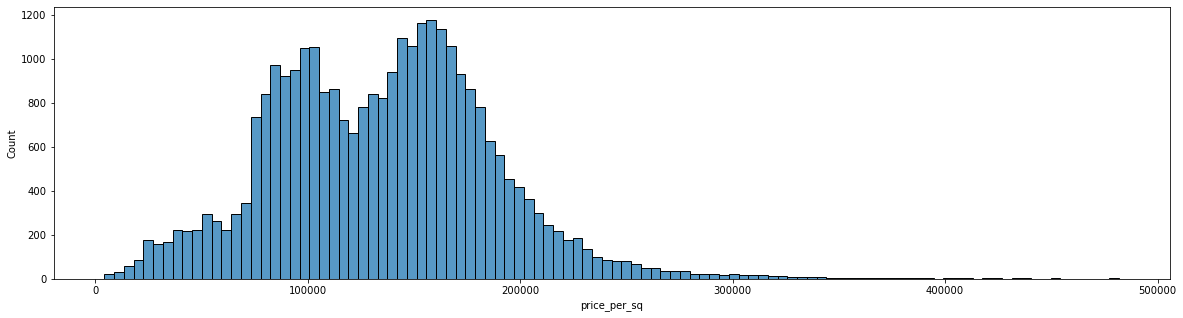

In [33]:
# Изучаем распределение
# Думаю, пики связаны с типом жилья
sns.histplot(df['price_per_sq'])

In [34]:
# Удаляем параметр

df = df.drop('price_per_sq', 1)

## ID_metro
код станции метро

In [35]:
# Пропусков нет
df[df['ID_metro'].isna()].ID_metro.size

0

<AxesSubplot:xlabel='ID_metro', ylabel='Count'>

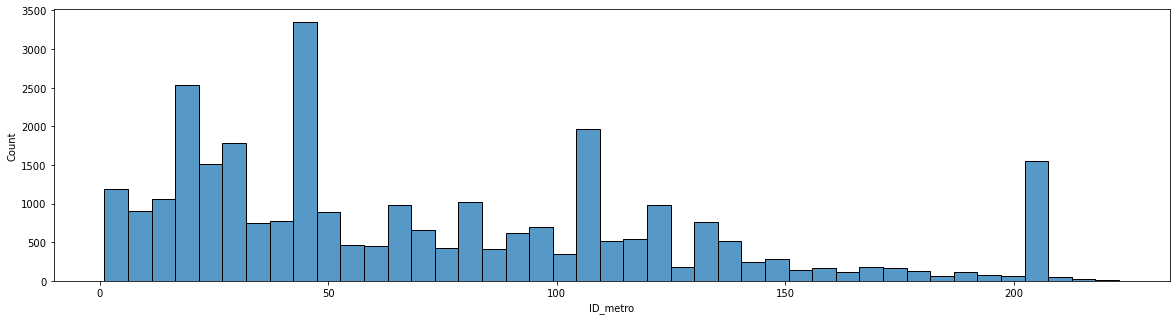

In [36]:
# Смотрим распределение
# Судя по всему, данные корректны
# Длинный правый хвост - это новые станции метро, а пики - метро в спальных районах
sns.histplot(df['ID_metro'])

In [37]:
# Изменяем тип переменной на категориальную
df['ID_metro'] = pd.Categorical(df['ID_metro'])
get_score(df)

Качество модели:  0.1845883048828116


## build_year
год постройки

In [38]:
# Ищем выбросы и ошибки вручную

df[~df.build_year.isna()][main_colums].sort_values(by='build_year').head(10)

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,price_doc
15536,38,38.0,3.0,17.0,1.0,0.0,1.0,0.0,1.0,4358970
21926,46,46.0,19.0,24.0,1.0,0.0,1.0,0.0,1.0,5972181
12809,82,NaN,18.0,0.0,1.0,0.0,3.0,0.0,1.0,11214102
28731,51,51.0,1.0,3.0,1.0,0.0,2.0,1.0,1.0,2977151
12808,69,69.0,16.0,0.0,6.0,0.0,2.0,0.0,NaN,7996680
28722,39,39.0,15.0,17.0,1.0,0.0,1.0,1.0,1.0,4504859
28721,40,NaN,2.0,17.0,1.0,0.0,1.0,1.0,1.0,5902013
28717,62,62.0,1.0,20.0,1.0,0.0,2.0,1.0,1.0,7860056
22045,37,37.0,8.0,17.0,1.0,0.0,1.0,0.0,1.0,4835861
28701,60,NaN,7.0,20.0,1.0,0.0,2.0,1.0,1.0,8000000


In [39]:
df[~df.build_year.isna()][main_colums].sort_values(by='build_year').tail(10)

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,price_doc
16833,69,69.0,2.0,3.0,1.0,2017.0,3.0,0.0,1.0,3748680
29463,51,51.0,8.0,17.0,4.0,2017.0,2.0,10.0,1.0,6430515
29460,57,40.0,9.0,24.0,6.0,2017.0,2.0,10.0,1.0,9100650
30274,38,38.0,12.0,17.0,1.0,2017.0,1.0,6.0,1.0,5886193
29458,36,36.0,18.0,18.0,1.0,2017.0,1.0,1.0,1.0,6284948
29455,37,20.0,9.0,18.0,4.0,2017.0,1.0,10.0,1.0,6531217
30078,83,60.0,3.0,24.0,6.0,2017.0,3.0,12.0,1.0,10439653
29767,81,77.0,7.0,10.0,2.0,2018.0,2.0,10.0,1.0,18800000
15220,41,24.0,4.0,9.0,2.0,4965.0,2.0,5.0,3.0,8400000
10089,37,16.0,8.0,12.0,1.0,20052009.0,1.0,9.0,33.0,9000000


In [40]:
# Удаляем явные ошибки

df['build_year'] = np.where(
    df['build_year'] > 2018,
    np.NaN,
    df['build_year']
)

get_score(df)

Качество модели:  0.6240836452150449


In [41]:
# Левый хвост проанализировать не удалось, явные ошибки в данных. Заменяем нули и единицы и повторяем анализ

df['build_year'] = np.where(
    df['build_year'] > 1,
    df['build_year'],
    np.NaN
)

get_score(df)

df[~df.build_year.isna()][main_colums].sort_values(by='build_year').head(10)

Качество модели:  0.6240836422819677


,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,price_doc
19127,30,30.0,4.0,5.0,2.0,3.0,1.0,5.0,3.0,5400000
11271,62,33.0,3.0,0.0,1.0,3.0,2.0,0.0,3.0,3759912
13992,126,NaN,15.0,20.0,4.0,20.0,3.0,10.0,1.0,17793902
30275,35,20.0,4.0,12.0,1.0,71.0,1.0,9.0,2.0,4200000
30150,107,1.0,6.0,1.0,1.0,215.0,3.0,1.0,1.0,19420850
26332,42,26.0,4.0,5.0,5.0,1691.0,2.0,5.0,NaN,6250000
27751,30,13.0,1.0,4.0,2.0,1860.0,1.0,9.0,2.0,2000000
14158,37,19.0,13.0,16.0,1.0,1860.0,1.0,9.0,2.0,6200000
17212,50,25.0,4.0,4.0,2.0,1876.0,2.0,7.0,2.0,10950000
29517,187,139.0,3.0,6.0,2.0,1886.0,8.0,13.0,4.0,42300000


In [42]:
# Удаляем явные ошибки

df['build_year'] = np.where(
    df['build_year'] < 1860,
    np.NaN,
    df['build_year']
)

get_score(df)

Качество модели:  0.6240837803013978


<AxesSubplot:xlabel='build_year'>

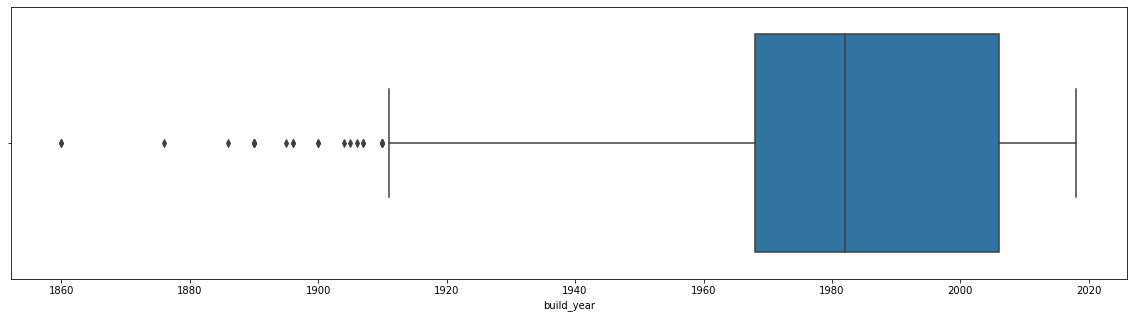

In [43]:
# В ящике с усами видны вероятные выбросы

sns.boxplot(df[~df['build_year'].isna()]['build_year'])

In [44]:
# Подсчитываем выбросы
df[df.build_year <= 1900].build_year.size

14

In [45]:
# Некритично, удаляем

df = df[~(df.build_year <= 1900)]
get_score(df)

Качество модели:  0.6281846524459853


<AxesSubplot:xlabel='build_year', ylabel='Count'>

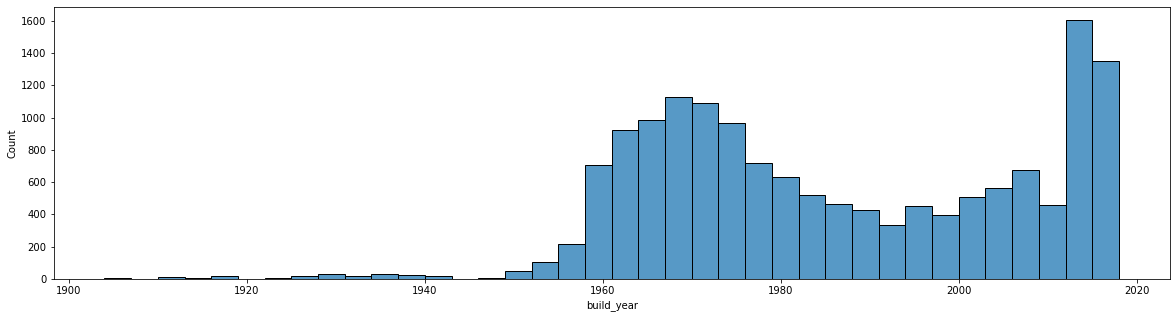

In [46]:
# Изучаем распределение
sns.histplot(df[~df['build_year'].isna()]['build_year'])

In [47]:
# Довоенных зданий немного, и, как правило, c существенными отличиями, например, деревянными перекрытиями.
# Подсчитываем количество таких зданий

df[df.build_year < 1945].build_year.size

183

In [48]:
# Довоенных зданий достаточно много, помечаем такие здания индикатором

df['after_ww2'] = np.where(
    df.build_year > 1945,
    1,
    0
)

get_score(df)

Качество модели:  0.6283027296760231


In [49]:
# Помечаем пропуски в данных

df['empty_build_year'] = np.where(
    df['build_year'].isna(),
    1,
    0
)

get_score(df)

Качество модели:  0.6295287209520902


In [50]:
# Очевидный способ заполнить год постройки - выбрать средний возраст зданий у того же метро.

metro = df.groupby('ID_metro').agg('mean').to_dict()

df.build_year = df.build_year.fillna(df.ID_metro.map(metro['build_year']))

get_score(df)

Качество модели:  0.6258328443842045


In [51]:
# Проверяем, сколько осталось пропусков

df[df['build_year'].isna()]['build_year'].size

14

In [52]:
# Заполняем оставшиеся пропуски средним

df.build_year = df.build_year.fillna(df['build_year'].mean())
get_score(df)

Качество модели:  0.6305600098423793


## material
Материал дома

In [53]:
# Много пропусков

df[df['material'].isna()].material.size

9273

<AxesSubplot:xlabel='material', ylabel='Count'>

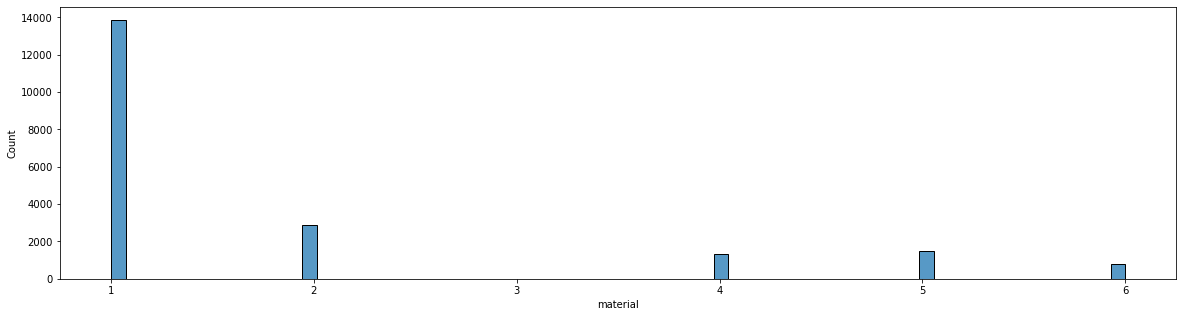

In [54]:
# Смотрим распределение

sns.histplot(df['material'])

In [55]:
# Класс 3 слишком маленький
df[df.material == 3].material.size

1

In [56]:
# Вероятней всего, ошибка в данных, удаляем

df = df[~(df.material == 3)]
get_score(df)

Качество модели:  0.6261522566465804


In [57]:
# Помечаем пропуски в данных

df['empty_material'] = np.where(
    df['material'].isna(),
    1,
    0
)

get_score(df)

Качество модели:  0.6262973090779242


In [58]:
# Заполняем категорию простой моделью на основании метро и года постройки

df = fill_category(df, ['ID_metro', 'build_year'], 'material')
get_score(df)

Качество модели:  0.6262451200600775


In [59]:
# Изменяем тип переменной на категориальную
df['material'] = pd.Categorical(df['material'])
get_score(df)

Качество модели:  0.6268217348898089


## state
состояние

In [60]:
# Много пропусков

df[df['state'].isna()].state.size

13218

<AxesSubplot:xlabel='state', ylabel='Count'>

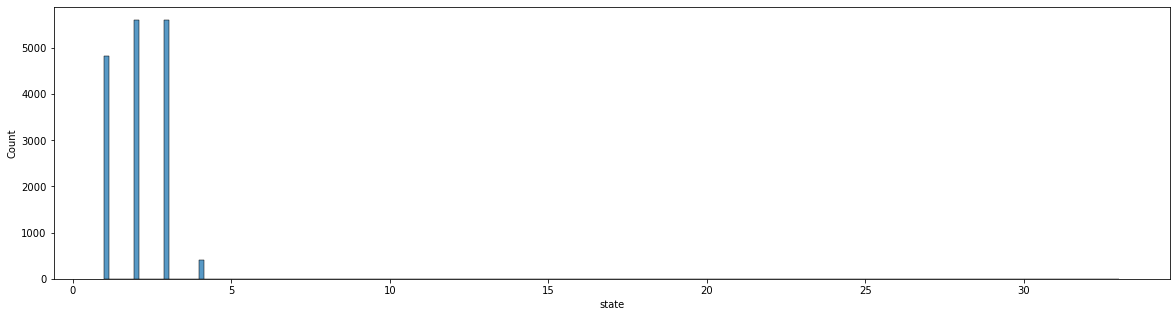

In [61]:
# Смотрим распределение

sns.histplot(df['state'])

In [62]:
# Удаляем явную ошибку в данных
df['state'] = np.where(
    df['state'] > 4,
    np.NaN,
    df['state']
)

get_score(df)

Качество модели:  0.626980745062377


<AxesSubplot:xlabel='state', ylabel='Count'>

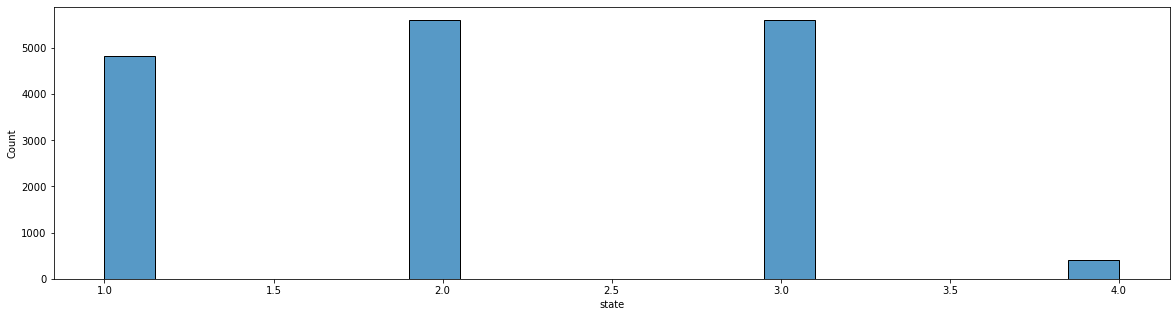

In [63]:
# Снова смотрим распределение

sns.histplot(df['state'])

In [64]:
# Помечаем пропуски в данных. Заполняем их новой категорией

df['empty_state'] = np.where(
    df['state'].isna(),
    1,
    0
)

df['state'] = df['state'].fillna(0)

get_score(df)

Качество модели:  0.627161949386674


In [65]:
# Изменяем тип переменной на категориальную
df['state'] = pd.Categorical(df['state'])
get_score(df)

Качество модели:  0.6297373266820145


## kitch_sq
площадь кухни

In [66]:
# Ищем выбросы и ошибки вручную

df[~df.kitch_sq.isna()][main_colums].sort_values(by='kitch_sq').head(10)

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,price_doc
20048,44,NaN,17.0,17.0,1.0,2008.556858,1.0,0.0,0.0,5561042
13951,45,19.0,3.0,0.0,1.0,2014.000000,1.0,0.0,1.0,2938008
13954,41,NaN,11.0,0.0,1.0,2008.556858,2.0,0.0,0.0,4821600
25758,49,NaN,3.0,0.0,1.0,2003.197917,1.0,0.0,0.0,5899672
25731,34,34.0,6.0,17.0,1.0,2008.556858,1.0,0.0,1.0,3505109
25719,63,NaN,4.0,0.0,1.0,2005.425770,2.0,0.0,0.0,7122731
25718,56,NaN,2.0,0.0,1.0,1979.101695,2.0,0.0,0.0,7716800
13949,80,80.0,23.0,23.0,6.0,2017.000000,2.0,0.0,1.0,13480320
25714,93,NaN,2.0,0.0,1.0,2001.511628,3.0,0.0,0.0,6935950
25695,31,18.0,1.0,1.0,2.0,2002.000000,1.0,0.0,0.0,500000


In [67]:
df[~df.kitch_sq.isna()][main_colums].sort_values(by='kitch_sq').tail(10)

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,price_doc
28434,96,96.0,22.0,25.0,1.0,2016.000000,3.0,96.0,1.0,15765120
28997,50,30.0,4.0,17.0,1.0,2014.000000,2.0,97.0,1.0,6500000
20053,112,112.0,3.0,3.0,1.0,2015.000000,3.0,112.0,3.0,8200031
27996,112,112.0,3.0,3.0,1.0,2015.000000,3.0,112.0,3.0,10500000
27931,112,112.0,3.0,3.0,1.0,2015.000000,3.0,112.0,3.0,10950065
8949,123,123.0,3.0,10.0,2.0,2013.000000,3.0,123.0,3.0,8287230
11520,38,23.0,11.0,14.0,5.0,1971.000000,2.0,620.0,2.0,6300000
13117,31,19.0,5.0,1.0,1.0,1971.795455,1.0,1970.0,3.0,3650000
10368,79,41.0,5.0,17.0,6.0,2013.000000,3.0,2013.0,1.0,7281225
21415,43,43.0,3.0,1.0,1.0,2014.000000,1.0,2014.0,1.0,3801200


In [68]:
# Если кухня есть, очевидно ее площадь минимум 3 метра, удаляем ошибки

df['kitch_sq'] = np.where(
    df['kitch_sq'] < 3,
    np.NaN,
    df['kitch_sq']
)

get_score(df)

# Ошибки все еще есть, попробуем отловить их позднее
df[~df.kitch_sq.isna()][main_colums].sort_values(by='kitch_sq').head(10)

Качество модели:  0.6297375042075937


,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,price_doc
23343,20,12.0,8.0,9.0,2.0,1970.0,1.0,3.0,2.0,4850000
23521,24,16.0,5.0,5.0,2.0,1970.0,1.0,3.0,3.0,3200000
27347,30,19.0,1.0,17.0,1.0,2011.0,1.0,3.0,0.0,2000000
22479,20,12.0,9.0,9.0,2.0,1970.0,1.0,3.0,2.0,3500000
17251,18,11.0,4.0,5.0,2.0,1964.0,1.0,3.0,2.0,4000000
9605,17,10.0,4.0,5.0,2.0,1968.0,1.0,3.0,2.0,3700000
10379,24,16.0,1.0,5.0,2.0,1965.0,1.0,3.0,2.0,3725000
20865,21,14.0,1.0,5.0,1.0,1964.0,1.0,3.0,2.0,4500000
9696,31,18.0,2.0,1.0,1.0,1950.0,2.0,3.0,3.0,7750000
10311,21,13.0,9.0,9.0,2.0,1974.0,1.0,3.0,2.0,6000000


In [69]:
# Кухня более 30 метров, вероятно, является ошибкой

df['kitch_sq'] = np.where(
    df['kitch_sq'] > 30,
    np.NaN,
    df['kitch_sq']
)

get_score(df)

Качество модели:  0.6297933656574939


In [70]:
# Кухня с площадью более половину квартиры, так же, вероятно, является ошибкой

df['kitch_sq'] = np.where(
    df['kitch_sq'] > (df['full_sq'] * 0.5),
    np.NaN,
    df['kitch_sq']
)


get_score(df)

df[~df.kitch_sq.isna()][main_colums].sort_values(by='kitch_sq').tail(10)

Качество модели:  0.6298130257413548


,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,price_doc
22757,104,48.0,2.0,22.0,4.0,2007.0,3.0,27.0,3.0,19800000
22777,176,108.0,2.0,10.0,4.0,2013.0,3.0,28.0,1.0,39551828
27429,78,22.0,34.0,40.0,1.0,2013.0,1.0,28.0,3.0,17924168
27118,78,23.0,6.0,40.0,4.0,2014.0,1.0,29.0,1.0,16321500
18188,81,32.0,3.0,4.0,2.0,1978.0,1.0,29.0,3.0,7500000
26336,78,23.0,12.0,40.0,4.0,2012.0,1.0,29.0,1.0,17409480
15729,84,22.0,5.0,19.0,4.0,1984.0,2.0,30.0,3.0,20300000
18792,66,14.0,2.0,20.0,6.0,2006.0,1.0,30.0,4.0,24000000
28977,121,80.0,3.0,3.0,2.0,2015.0,5.0,30.0,1.0,9535766
18344,165,124.0,18.0,28.0,6.0,2009.0,1.0,30.0,1.0,13000000


<AxesSubplot:xlabel='kitch_sq'>

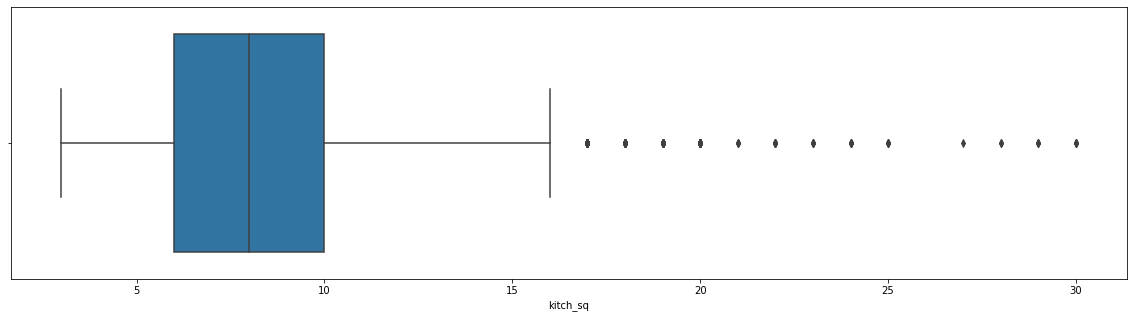

In [71]:
# В ящике с усами ничего интересного, длинный хвост мы уже обрезали

sns.boxplot(df[~df['kitch_sq'].isna()]['kitch_sq'])

<AxesSubplot:xlabel='kitch_sq', ylabel='Count'>

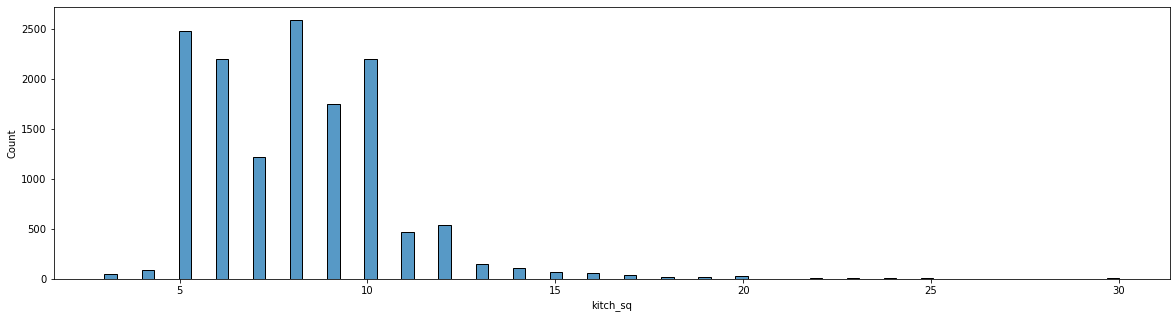

In [72]:
# Изучим распределение
sns.histplot(df[~df['kitch_sq'].isna()]['kitch_sq'])

In [73]:
# Вероятно, кухни с площадью менее 5 или более 25 метров тоже являются ошибками в данных

df['kitch_sq'] = np.where(
    ((df['kitch_sq'] > 25) | (df['kitch_sq'] < 15)),
    np.NaN,
    df['kitch_sq']
)

get_score(df)

Качество модели:  0.6302581842811208


In [74]:
# Помечаем пропуски в данных

df['empty_kitch_sq'] = np.where(
    df['kitch_sq'].isna(),
    1,
    0
)

get_score(df)

Качество модели:  0.6301742531677832


In [75]:
# Заполнения пропуски простой моделью, использующую общую площадь, материал дома и год постройки

df = fill_value(df, ['full_sq', 'material', 'build_year'], 'kitch_sq')
get_score(df)

Качество модели:  0.6297812479909971


## life_sq
жилая площадь

In [76]:
# Ищем выбросы вручную

df[~df.life_sq.isna()][main_colums].sort_values(by='life_sq').head(10)

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,price_doc
30273,78,0.0,12.0,0.0,1.0,2014.000000,3.0,16.491185,3.0,1085877
21708,56,0.0,13.0,19.0,1.0,2008.556858,2.0,16.158967,1.0,4278104
18764,72,0.0,10.0,0.0,2.0,2016.000000,2.0,17.190496,2.0,7731241
23254,77,0.0,16.0,22.0,1.0,2008.556858,3.0,16.474295,1.0,5615703
25366,64,0.0,3.0,0.0,1.0,2015.000000,2.0,16.281311,1.0,6708000
19819,61,0.0,7.0,0.0,1.0,2015.000000,2.0,16.236264,3.0,7325634
17660,37,0.0,17.0,17.0,1.0,2014.000000,1.0,15.875546,3.0,3712661
23032,77,0.0,10.0,1.0,2.0,2016.000000,3.0,17.265574,1.0,11523511
20741,55,0.0,6.0,0.0,1.0,2008.556858,2.0,16.143952,1.0,4725120
27651,77,0.0,4.0,24.0,4.0,2016.000000,1.0,17.434360,1.0,8758453


In [77]:
df[~df.life_sq.isna()][main_colums].sort_values(by='life_sq').tail(10)

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,price_doc
18669,209,209.0,0.0,3.0,4.0,2007.000000,0.0,19.413320,1.0,10500000
13629,45,259.0,5.0,5.0,1.0,1970.000000,2.0,15.980515,0.0,4900000
1084,44,281.0,6.0,NaN,1.0,1976.913580,NaN,15.967881,0.0,6200000
9237,47,301.0,4.0,12.0,1.0,1973.000000,2.0,16.011579,2.0,5600000
21080,52,349.0,1.0,9.0,1.0,1979.000000,3.0,16.088724,2.0,7200000
4385,73,426.0,17.0,NaN,1.0,1979.444444,NaN,16.404205,0.0,11918400
26342,75,435.0,3.0,22.0,1.0,1999.000000,3.0,16.440972,3.0,12900000
9256,77,458.0,12.0,16.0,1.0,1996.000000,3.0,16.469970,3.0,13750000
9646,82,802.0,5.0,NaN,1.0,1980.840000,NaN,16.539826,0.0,12031350
13546,79,7478.0,8.0,17.0,1.0,2014.000000,3.0,16.506201,1.0,7705000


In [78]:
# Жилая площадь должна быть меньше, чем общая площадь минус площадь кухни

df['life_sq'] = np.where(
    (df['life_sq'] < (df['full_sq'] - df['kitch_sq'])),
    df['life_sq'],
    np.NaN
)

get_score(df)

Качество модели:  0.6315061435753055


In [79]:
# Левый хвост проанализировать не удалось, явные ошибки в данных. Заменяем нули и единицы повторяем анализ

df['life_sq'] = np.where(
    df['life_sq'] > 1,
    df['life_sq'],
    np.NaN
)

get_score(df)

df[~df.life_sq.isna()][main_colums].sort_values(by='life_sq').head(10)

Качество модели:  0.6315044075833299


,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,price_doc
11446,40,7.0,4.0,12.0,5.0,1966.000000,2.0,15.385946,2.0,8300000
22415,38,8.0,7.0,25.0,4.0,2009.000000,1.0,16.846341,0.0,9150000
21243,50,8.0,7.0,17.0,1.0,1984.000000,2.0,16.060415,2.0,2000000
20409,26,9.0,10.0,25.0,6.0,2012.000000,1.0,15.734787,1.0,2626800
6506,26,9.0,7.0,NaN,1.0,1978.010811,NaN,15.697978,0.0,4600000
1107,30,9.0,5.0,NaN,1.0,1973.608000,NaN,15.756524,0.0,4600000
13762,26,9.0,15.0,25.0,4.0,1967.000000,1.0,16.651687,3.0,3975000
28938,52,9.0,13.0,14.0,1.0,2002.000000,2.0,16.096646,2.0,10150000
23244,51,9.0,2.0,3.0,4.0,2010.000000,1.0,20.000000,4.0,5400000
15891,29,10.0,1.0,4.0,1.0,2015.000000,1.0,15.755765,0.0,1973210


In [80]:
# Жилая площадь должна быть не менее 10 метров

df['life_sq'] = np.where(
    df['life_sq'] < 10,
    np.NaN,
    df['life_sq']
)

get_score(df)

Качество модели:  0.6315011831564789


<AxesSubplot:xlabel='life_sq'>

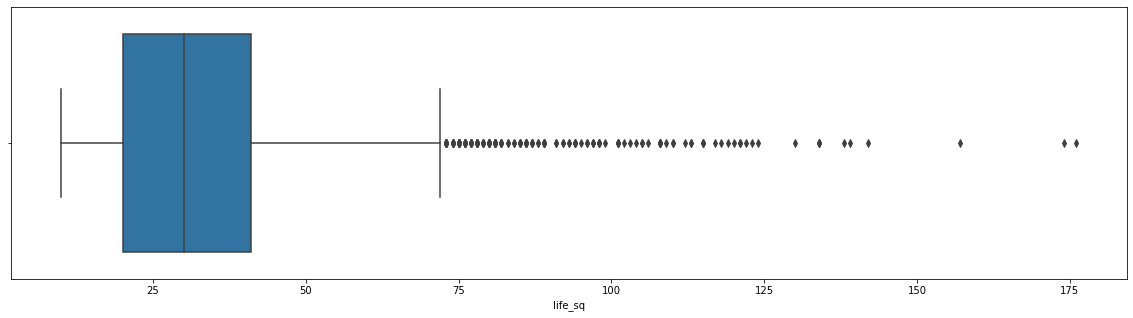

In [81]:
# Изучаем ящик с усами
sns.boxplot(df[~df['life_sq'].isna()]['life_sq'])

In [82]:
# Подсчитываем выбросы
df[df.life_sq > 125].life_sq.size

10

In [83]:
# Некритично, удаляем
df['life_sq'] = np.where(
    df['life_sq'] > 125,
    np.NaN,
    df['life_sq']
)

get_score(df)

Качество модели:  0.6309093627443024


<AxesSubplot:xlabel='life_sq', ylabel='Count'>

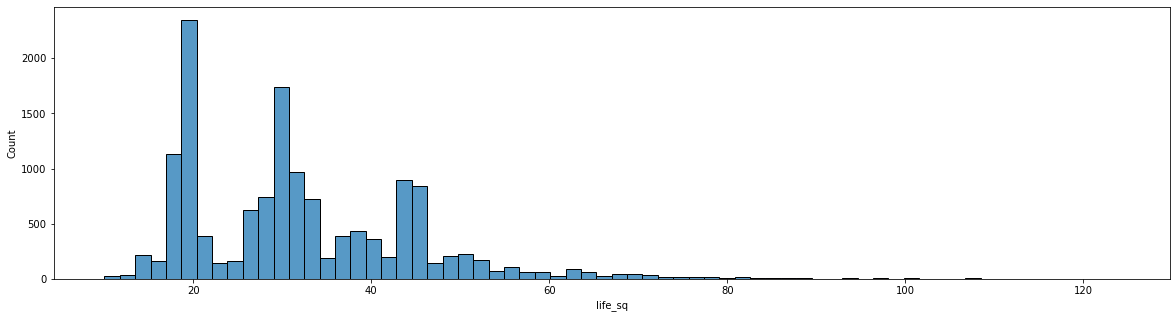

In [84]:
# Изучаем распределение, четко видно пики по числу комнат
sns.histplot(df[~df['life_sq'].isna()]['life_sq'])

In [85]:
# Помечаем пропуски в данных

df['empty_life_sq'] = np.where(
    df['life_sq'].isna(),
    1,
    0
)

get_score(df)

Качество модели:  0.6324204184206244


In [86]:
# Для заполнения пропусков используем простую модель

df = fill_value(df, ['full_sq', 'kitch_sq', 'material', 'build_year'], 'life_sq')

get_score(df)

Качество модели:  0.6303715721648917


## num_room
количество комнат

In [87]:
# Ищем выбросы вручную

df[~df.num_room.isna()][main_colums].sort_values(by='num_room').head(10)

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,price_doc
18123,112,68.054212,3.0,3.0,1.0,1990.682609,0.0,16.993684,1.0,7600002
27454,135,79.707359,3.0,3.0,6.0,2013.000000,0.0,17.371832,1.0,9308100
10452,48,23.759895,15.0,0.0,1.0,2013.000000,0.0,16.040373,1.0,7675120
15992,58,31.191087,10.0,0.0,1.0,2005.425770,0.0,16.187920,0.0,6632021
20670,79,43.838985,4.0,0.0,1.0,2013.212598,0.0,16.505930,0.0,7402800
24880,34,18.146601,9.0,16.0,5.0,1982.000000,0.0,15.301364,3.0,5400000
23191,84,46.050758,3.0,15.0,2.0,2008.556858,0.0,17.368120,1.0,7580000
18669,209,127.079775,0.0,3.0,4.0,2007.000000,0.0,19.413320,1.0,10500000
11791,54,28.899626,24.0,0.0,1.0,2003.000000,0.0,16.127022,1.0,8383079
21439,74,41.000000,12.0,0.0,1.0,2008.556858,0.0,16.429248,0.0,8150340


In [88]:
df[~df.num_room.isna()][main_colums].sort_values(by='num_room').tail(10)

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,price_doc
10076,106,61.252046,2.0,2.0,1.0,2014.000000,6.0,16.911622,1.0,4980000
13242,170,123.000000,4.0,4.0,2.0,1943.785714,6.0,18.637151,0.0,34800000
28622,129,83.000000,2.0,7.0,2.0,1910.000000,6.0,18.009874,2.0,29700000
28081,219,101.000000,2.0,2.0,4.0,2014.000000,6.0,16.000000,1.0,18000000
18990,145,109.000000,5.0,6.0,2.0,1936.000000,7.0,18.259079,3.0,25500000
21897,159,115.000000,2.0,4.0,2.0,1904.000000,8.0,18.458276,2.0,35000000
29172,59,33.000000,20.0,22.0,1.0,2000.000000,10.0,16.201067,3.0,11000000
17764,58,34.000000,1.0,2.0,1.0,1992.000000,10.0,16.183295,2.0,6000000
26713,51,30.000000,14.0,17.0,1.0,1984.000000,17.0,16.075431,3.0,13150000
11621,40,19.000000,17.0,17.0,1.0,2011.000000,19.0,15.919559,3.0,2630000


In [89]:
# Удаляем ошибки в данных

df['num_room'] = np.where(
    ((df['num_room'] == 0) | (df['num_room'] > 6)),
    np.NaN,
    df['num_room']
)

get_score(df)

Качество модели:  0.6304380746024527


<AxesSubplot:xlabel='num_room'>

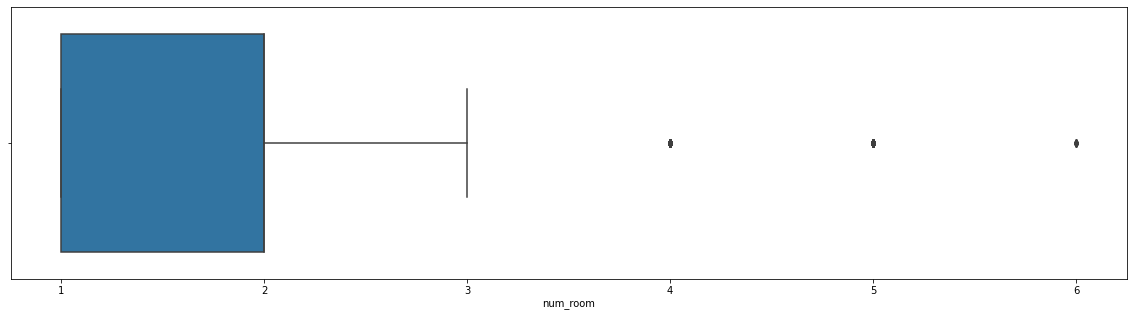

In [90]:
# Изучаем ящик с усами.
sns.boxplot(df[~df['num_room'].isna()]['num_room'])

In [91]:
# Подсчитываем число 4+ комнатых квартир
df[df.num_room > 3].num_room.size

454

In [92]:
# Многокомнатных квартир относительно много, помечаем индикатором

df['many_rooms'] = np.where(
    df.num_room > 3,
    1,
    0
)

get_score(df)

Качество модели:  0.6356225426161014


<AxesSubplot:xlabel='num_room', ylabel='Count'>

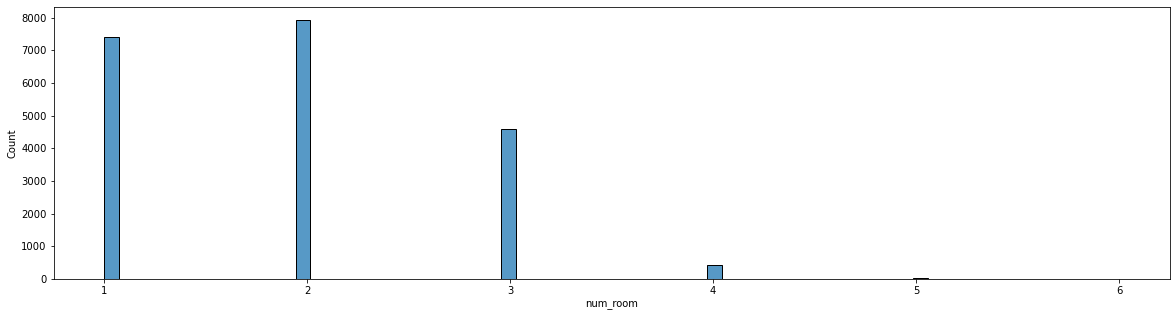

In [93]:
# Изучаем распределение
sns.histplot(df[~df['num_room'].isna()]['num_room'])

In [94]:
# Для поиска выбросов и ошибок добавляем параметр размер комнаты 
df['room_sq'] = (df['full_sq'] - df['kitch_sq'])/ df['num_room']

get_score(df)

Качество модели:  0.636286279933467


In [95]:
# Ищем выбросы вручную

df[~df.room_sq.isna()][main_colums+['room_sq']].sort_values(by='room_sq').head(10)

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,price_doc,room_sq
8056,11,11.382777,2.0,5.0,2.0,1907.0,1.0,16.237000,3.0,2750000,-5.237000
24314,12,4.791097,4.0,5.0,2.0,1965.0,1.0,16.271993,2.0,3600000,-4.271993
29134,12,4.791097,1.0,5.0,2.0,1965.0,1.0,16.271993,2.0,2590000,-4.271993
19221,12,5.165593,4.0,5.0,2.0,1962.0,1.0,16.270960,3.0,3000000,-4.270960
20931,13,5.814162,4.0,5.0,2.0,1962.0,1.0,16.285976,2.0,3650000,-3.285976
19905,13,5.814162,4.0,5.0,2.0,1962.0,1.0,16.285976,2.0,3450000,-3.285976
19459,14,6.088235,1.0,5.0,2.0,1965.0,1.0,16.302025,2.0,3750000,-2.302025
26246,14,7.711049,5.0,5.0,2.0,1952.0,1.0,16.297547,3.0,2000000,-2.297547
23441,14,7.711049,4.0,5.0,2.0,1952.0,1.0,16.297547,3.0,2000000,-2.297547
25198,15,7.111299,5.0,5.0,2.0,1962.0,1.0,16.316007,3.0,2000000,-1.316007


In [96]:
df[~df.room_sq.isna()][main_colums+['room_sq']].sort_values(by='room_sq').tail(10)

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,price_doc,room_sq
24087,138,89.000000,3.0,3.0,2.0,2013.00000,1.0,18.180492,4.0,5490000,119.819508
18723,143,117.000000,3.0,14.0,6.0,2013.00000,1.0,17.491956,1.0,24000000,125.508044
9821,146,87.467216,1.0,2.0,1.0,2011.81768,1.0,17.511494,1.0,5571000,128.488506
29583,160,94.934923,3.0,3.0,2.0,2011.81768,1.0,18.510428,0.0,7950000,141.489572
19755,160,96.547178,3.0,3.0,1.0,2011.81768,1.0,17.721713,0.0,7552500,142.278287
18652,160,96.547178,1.0,1.0,1.0,2011.81768,1.0,17.721713,0.0,7552500,142.278287
18344,165,124.000000,18.0,28.0,6.0,2009.00000,1.0,17.820922,1.0,13000000,147.179078
20915,174,106.699242,7.0,17.0,5.0,2000.00000,1.0,17.409748,3.0,44000000,156.590252
17138,172,110.244984,10.0,12.0,2.0,1955.00000,1.0,15.000000,1.0,8000000,157.000000
27496,209,127.929788,37.0,1.0,1.0,2015.00000,1.0,18.458573,1.0,44682580,190.541427


In [97]:
# Слабо представляю себе комнату с площадью менее 8 метров
df['num_room'] = np.where(
    df['room_sq'] < 8,
    np.NaN,
    df['num_room']
)

get_score(df)

Качество модели:  0.6362853729465534


In [98]:
# Комнаты более 40 метров тоже, вероятней всего, являются ошибкой
df['num_room'] = np.where(
    df['room_sq'] > 40,
    np.NaN,
    df['num_room']
)

df['room_sq'] = (df['full_sq'] - df['kitch_sq'])/ df['num_room']

get_score(df)

Качество модели:  0.6359448884983443


<AxesSubplot:xlabel='room_sq'>

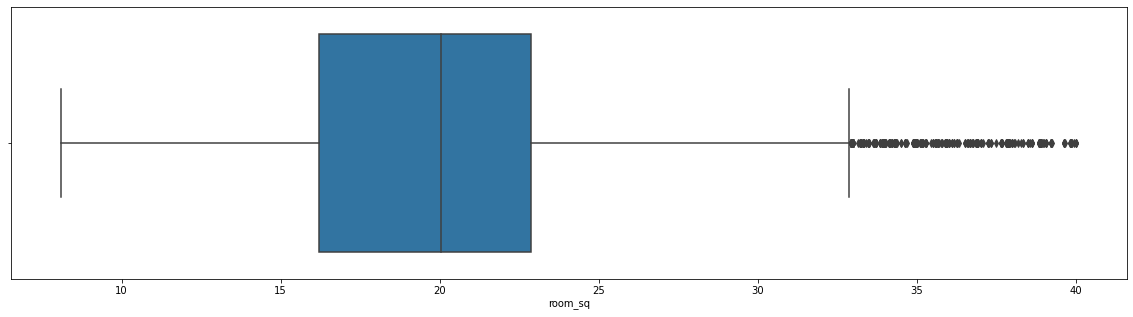

In [99]:
# Изучаем ящик с усами.
sns.boxplot(df[~df['room_sq'].isna()]['room_sq'])

<AxesSubplot:xlabel='room_sq', ylabel='Count'>

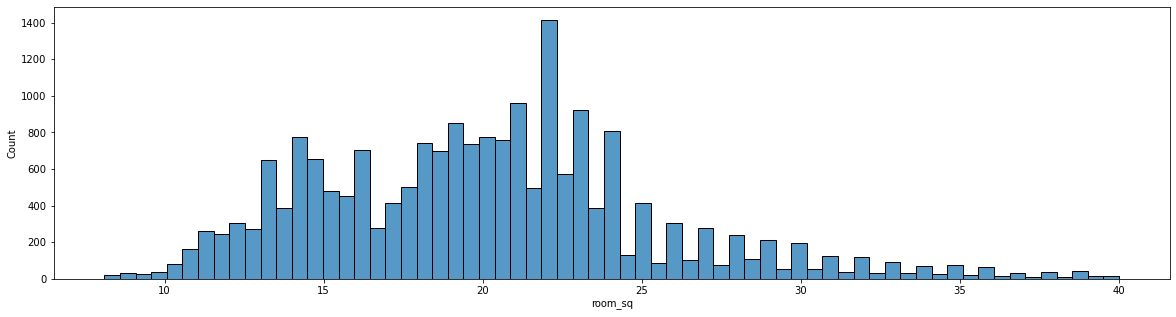

In [100]:
# Изучаем распределение
sns.histplot(df[~df['room_sq'].isna()]['room_sq'])

In [101]:
# Помечаем пропуски в данных

df['empty_num_room'] = np.where(
    df['num_room'].isna(),
    1,
    0
)

get_score(df)

Качество модели:  0.6362941452126488


In [102]:
# Для заполнения пропусков используем простую модель

df = fill_value(df, ['full_sq','life_sq', 'kitch_sq', 'material', 'build_year'], 'num_room')

get_score(df)

Качество модели:  0.6383305215676307


In [103]:
# Снова помечаем индикатором многокомнатные квартиры

df['many_rooms'] = np.where(
    df.num_room > 3,
    1,
    0
)

get_score(df)

Качество модели:  0.6345348410868364


In [104]:
# Удаляем признак

df = df.drop('room_sq', 1)

get_score(df)

Качество модели:  0.634527722322836


## floor
этаж

In [105]:
df[~df.floor.isna()][main_colums].sort_values(by='floor').head(10)

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,price_doc
18669,209,127.079775,0.0,3.0,4.0,2007.000000,7.393321,19.413320,1.0,10500000
21222,74,40.373017,0.0,0.0,1.0,2015.000000,2.000000,16.431467,1.0,5802830
15363,58,30.713077,0.0,0.0,6.0,2005.425770,1.796490,16.213022,1.0,6867981
5085,157,75.000000,0.0,NaN,1.0,2008.556858,4.171758,17.675543,0.0,5000000
21921,160,95.139761,0.0,3.0,2.0,2010.176768,5.562564,18.509863,1.0,7267500
23637,78,42.364450,0.0,0.0,6.0,2016.000000,3.000000,16.516976,1.0,14995821
25424,81,39.000000,0.0,12.0,5.0,2008.000000,2.000000,15.000000,3.0,7650000
5333,181,79.000000,0.0,NaN,1.0,2008.556858,4.254929,18.035917,0.0,4500000
17250,41,24.808724,1.0,5.0,5.0,1965.000000,2.000000,15.400618,2.0,6400000
6487,47,27.000000,1.0,NaN,1.0,1975.302703,1.797095,16.012373,0.0,6000000


In [106]:
df[~df.floor.isna()][main_colums].sort_values(by='floor').tail(10)

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,price_doc
7334,88,50.073811,34.0,NaN,4.0,1995.217391,2.999673,17.592374,0.0,10608000
27553,105,34.000000,36.0,40.0,4.0,2012.000000,1.674770,17.853419,1.0,26720800
19417,71,38.000000,36.0,48.0,4.0,2010.000000,2.000000,17.342200,3.0,18700000
11499,86,46.806501,37.0,38.0,4.0,2011.000000,2.738672,17.567779,1.0,9366623
27496,209,127.929788,37.0,1.0,1.0,2015.000000,7.455092,18.458573,1.0,44682580
6413,84,51.298478,38.0,NaN,1.0,1979.433962,3.192020,16.569373,0.0,9824000
21606,74,38.000000,41.0,48.0,4.0,2013.000000,2.000000,17.388280,3.0,14500000
30311,65,39.000000,44.0,48.0,4.0,2000.000000,2.000000,17.248662,4.0,8857680
2499,64,34.508162,44.0,NaN,4.0,1995.217391,2.100651,17.231999,0.0,13000000
23584,57,33.000000,77.0,22.0,1.0,1986.000000,2.000000,16.166213,3.0,13700000


In [107]:
# Явный выброс, удаляем

df = df[df.floor < 77]
get_score(df)

Качество модели:  0.6404550031159332


In [108]:
# Удаляем явные ошибки

df['floor'] = np.where(
    df['floor'] == 0,
    np.NaN,
    df['floor']
)

get_score(df)

Качество модели:  0.6404550031159332


In [109]:
# Первый этаж сильно влияет на стоимость, добавляем индикатор

df['first_floor'] = np.where(
    df['floor'] == 1,
   1,
    0
)

get_score(df)

Качество модели:  0.6418759186573738


<AxesSubplot:xlabel='floor'>

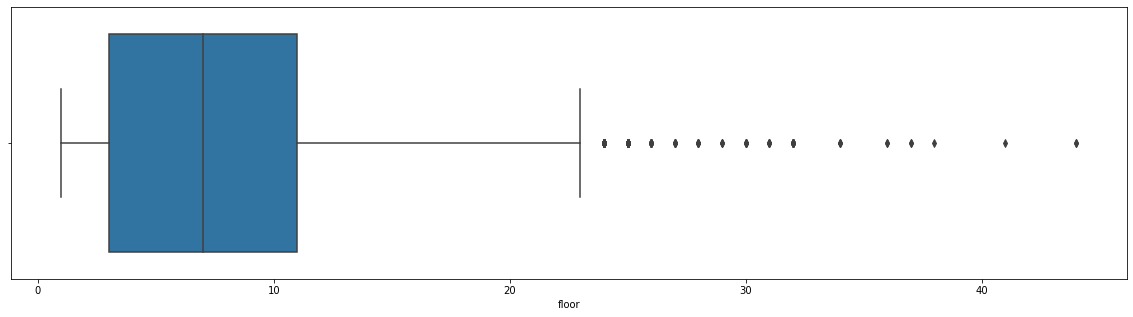

In [110]:
# Изучаем ящик с усами
sns.boxplot(df[~df['floor'].isna()]['floor'])

<AxesSubplot:xlabel='floor', ylabel='Count'>

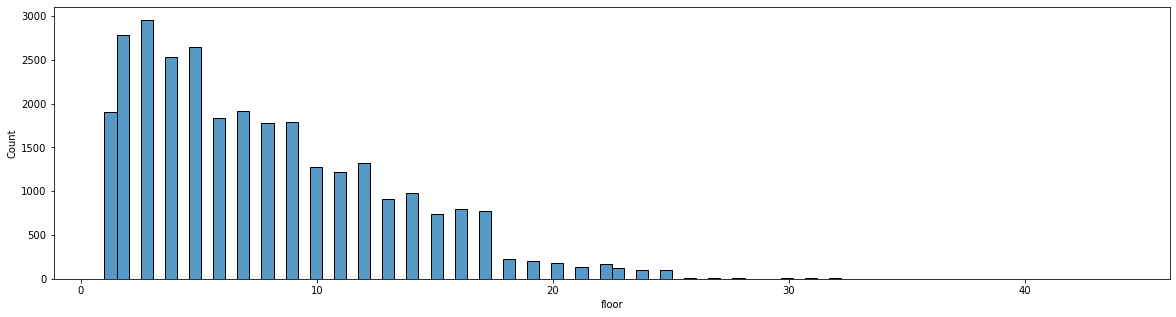

In [111]:
# Изучаем распределение, тоже ничего необычного
sns.histplot(df[~df['floor'].isna()]['floor'])

In [112]:
# Помечаем пропуски индикатором и заполняем средним
df['empty_floor'] = np.where(
    df['floor'].isna(),
   1,
    0
)

get_score(df)

Качество модели:  0.6422945940837521


In [113]:
# Заполняем средним
df.floor = df.floor.fillna(df.floor.mean())
get_score(df)

Качество модели:  0.6422945940809441


## max_floor
этажность здания

In [114]:
df[~df.max_floor.isna()][main_colums].sort_values(by='max_floor').head(10)

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,price_doc
11240,53,27.150330,2.0,0.0,1.0,2011.817680,1.0,16.115044,0.0,3696330
22556,51,26.260247,9.0,0.0,1.0,2008.556858,1.0,16.083889,0.0,5531900
22554,45,22.368835,2.0,0.0,1.0,2008.556858,1.0,15.993796,0.0,4431040
22552,55,28.050212,8.0,0.0,1.0,2015.000000,2.0,16.146171,1.0,4684993
14660,59,30.867611,7.0,0.0,1.0,2013.212598,2.0,16.205618,0.0,5875100
18231,78,48.000000,4.0,0.0,1.0,2015.000000,3.0,16.491530,3.0,8883798
18239,40,19.125991,2.0,0.0,1.0,2008.556858,1.0,15.918718,0.0,4950000
25285,45,22.368835,1.0,0.0,1.0,2008.556858,1.0,15.993796,0.0,4657550
25291,59,31.448796,5.0,0.0,1.0,2008.556858,2.0,16.204014,1.0,6626044
11156,74,45.046071,5.0,0.0,1.0,1977.565217,3.0,16.418573,0.0,14857740


In [115]:
df[~df.max_floor.isna()][main_colums].sort_values(by='max_floor').tail(10)

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,price_doc
19417,71,38.000000,36.0,48.0,4.0,2010.000000,2.0,17.342200,3.0,18700000
20487,125,74.000000,34.0,48.0,4.0,2011.000000,3.0,17.000000,1.0,16200000
30311,65,39.000000,44.0,48.0,4.0,2000.000000,2.0,17.248662,4.0,8857680
20102,122,60.000000,22.0,48.0,4.0,2011.000000,3.0,18.108340,1.0,6100000
21606,74,38.000000,41.0,48.0,4.0,2013.000000,2.0,17.388280,3.0,14500000
24020,135,59.000000,9.0,57.0,4.0,2007.000000,3.0,22.000000,4.0,56500000
20722,47,26.207518,4.0,99.0,2.0,1975.281690,1.0,16.801081,0.0,10238400
21852,46,22.539393,17.0,99.0,6.0,2008.556858,3.0,16.033913,0.0,6670000
21734,71,39.422577,5.0,99.0,6.0,2003.197917,2.0,16.407457,0.0,8484365
25940,63,33.840855,8.0,117.0,1.0,2010.176768,2.0,16.264634,1.0,7239838


In [116]:
# Удаляем вероятные ошибки
df['max_floor'] = np.where(
    df['max_floor'] > 60,
    np.NaN,
    df['max_floor']
)

get_score(df)

Качество модели:  0.6422982238446345


In [117]:
# Левый хвост проанализировать не удалось, явные ошибки в данных. Заменяем нули и единицы

df['max_floor'] = np.where(
    df['max_floor'] > 1,
    df['max_floor'],
    np.NaN
)

get_score(df)

df[~df.max_floor.isna()][main_colums].sort_values(by='max_floor').head(10)

Качество модели:  0.6423009003691198


,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,price_doc
23092,56,36.000000,8.0,2.0,2.0,1961.000000,2.000000,16.931302,2.0,10200000
15868,134,82.168594,1.0,2.0,1.0,1991.917293,3.000000,17.324453,1.0,5350000
29070,170,75.000000,1.0,2.0,6.0,2014.000000,3.966306,17.897722,3.0,16074000
27732,117,68.255605,2.0,2.0,5.0,2011.817680,4.009472,16.557929,0.0,9557190
25200,32,19.096438,2.0,2.0,5.0,1964.000000,1.000000,15.265133,2.0,990000
21663,135,82.339153,2.0,2.0,6.0,1991.917293,3.000000,17.364570,0.0,6777768
28221,117,66.000000,2.0,2.0,1.0,2016.000000,4.000000,17.077483,1.0,6488026
29685,90,38.000000,2.0,2.0,1.0,2011.817680,3.000000,16.670621,0.0,5535810
19588,84,46.983535,2.0,2.0,1.0,2014.000000,2.784476,16.581279,0.0,7212996
26435,56,26.974945,5.0,2.0,4.0,2014.000000,2.000000,17.118344,1.0,11239348


In [118]:
# Удаляем вероятные ошибки (максимальный этаж больше этажа квартиры)
df['max_floor'] = np.where(
    df['max_floor'] >  df['floor'],
    np.NaN,
    df['max_floor']
)

get_score(df)

Качество модели:  0.6423893857129034


<AxesSubplot:xlabel='max_floor'>

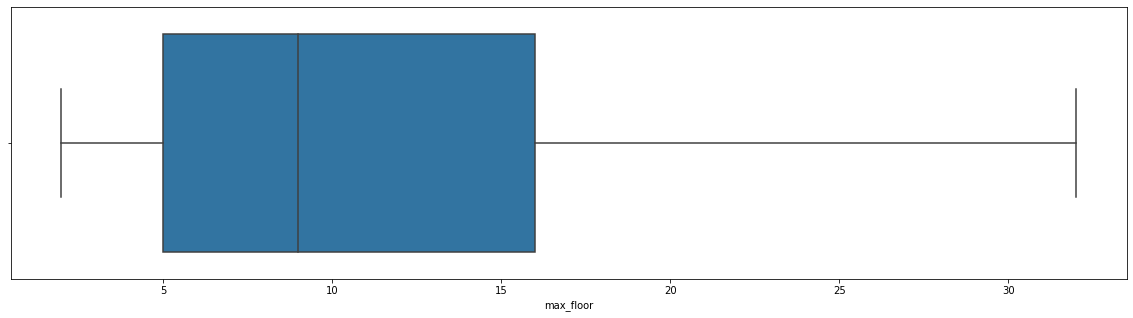

In [119]:
# Изучаем ящик с усами
sns.boxplot(df[~df['max_floor'].isna()]['max_floor'])

<AxesSubplot:xlabel='max_floor', ylabel='Count'>

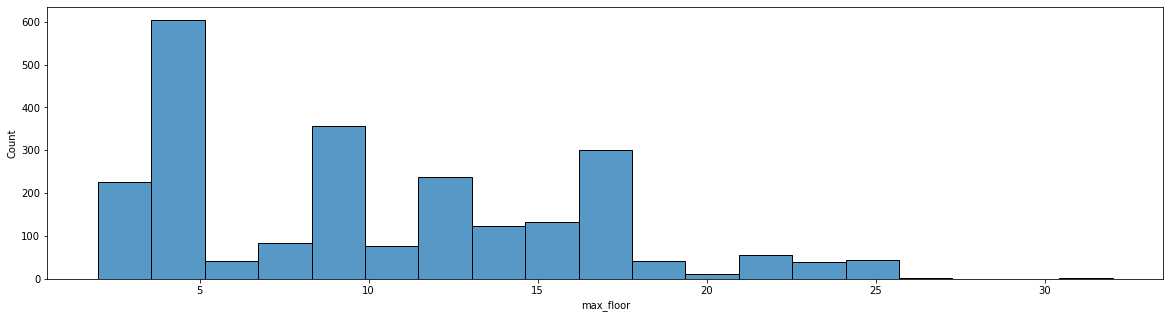

In [120]:
# Изучаем распределение, тоже ничего необычного
sns.histplot(df[~df['max_floor'].isna()]['max_floor'])

In [121]:
# Помечаем пропуски индикатором
df['empty_max_floor'] = np.where(
    df['max_floor'].isna(),
    1,
    0
)
get_score(df)

Качество модели:  0.6432652394683913


In [122]:
# Заполнения пропуски простой моделью

df = fill_value(df, ['ID_metro', 'material', 'build_year'], 'max_floor')
get_score(df)

Качество модели:  0.6431883006820333


## Дополнительные признаки

In [123]:
# Пропуски есть только в двух дополнительных признаках, заполняем
df['hospital_beds_raion'] = df['hospital_beds_raion'].fillna(0)
df['metro_min_walk'] = df['metro_min_walk'].fillna(df['metro_min_walk'].mean())
get_score(df)

Качество модели:  0.6432101478178063


In [124]:
# Применим автоматический поиск выбросов в дополнительных признаках

df = df[
    IsolationForest(
        bootstrap = True,
        n_jobs = -1,
        random_state = 42,
        contamination = 0.03
    ).fit_predict(df[extra_columns]) != -1
]
get_score(df)

Качество модели:  0.6493815777257892


## Результат

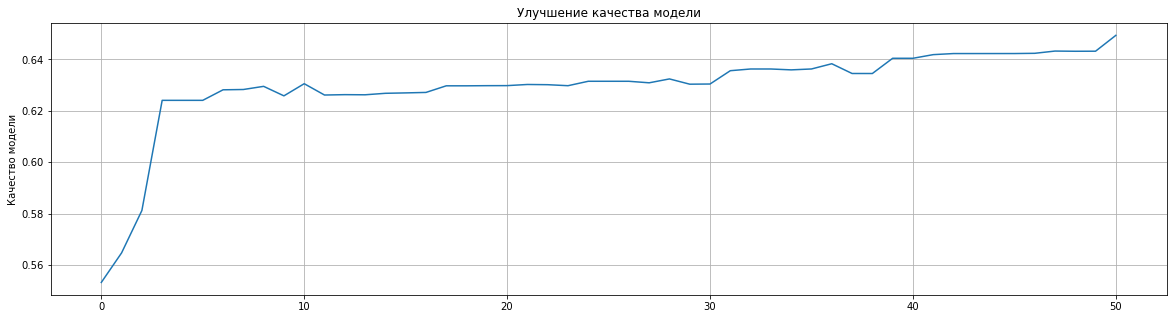

In [125]:
# В истории изменений качества существует много больших отрицательных величин и прыжков
# до фильтрации самых больших выбросов.
# Чтобы было лучше видно изменения качества, покажем график без них
quality_history
filtered = list(filter(lambda quality: quality > 0.5, quality_history))

plt.title("Улучшение качества модели")
plt.ylabel("Качество модели")
plt.grid()
plt.plot(range(len(filtered)), filtered)  # построение графика